It is an outdated version. Actual can be found at prosqa_construct.py.

In [19]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Example entity and concept names
ENTITY_NAMES = ["Fae", "Rex", "Sally", "Max", "Alex", "Sam", "Polly", "Stella", "Wren"]
CONCEPT_NAMES = ["wumpus", "yumpus", "zumpus", "dumpus", "rompus", "numpus", "tumpus", "vumpus", "impus", "jompus", "gorpus", "shumpus", "lempus", "sterpus", "grimpus", "lorpus", "brimpus"]
N_NODES = 23

def depth_to_root(G, node):
    roots = [n for n in G.nodes if G.in_degree(n) == 0]
    if not roots:
        return 0
    return min((nx.shortest_path_length(G, r, node) for r in roots if nx.has_path(G, r, node)), default=0)

def construct_graph(N=N_NODES, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    G = nx.DiGraph()
    G.add_nodes_from([0, 1])
    labels = {0: 1, 1: 2}
    # Labels: 1 (descendant of node 0), 2 (descendant of node 1), 3 (both), 0 (neither).
    groups = {0: set(), 1: {0}, 2: {1}, 3: set()}
    idx = 2
    while idx < N:
        n_in_nodes = np.random.poisson(1.5)
        rand = random.random()
        if rand <= 0.35:
            candidates = groups[0] | groups[1]
        elif rand <= 0.7:
            candidates = groups[0] | groups[2]
        else:
            candidates = set(G.nodes)
        if not candidates: # new, but it seems logical
            candidates = set(G.nodes)
        n_in_nodes = min(len(candidates), n_in_nodes)
        weights = np.array([depth_to_root(G, c) * 1.5 + 1 for c in candidates], dtype=float)
        # Define sampling weights to prioritize deeper nodes.
        # This way, the solution reasoning chain is expected to be longer.
        probs = weights / weights.sum() if weights.sum() > 0 else np.ones(len(candidates)) / len(candidates)
        # in_nodes = random.choices(list(candidates), weights=weights, k=n_in_nodes) # ???
        in_nodes = np.random.choice(list(candidates), size=n_in_nodes, 
        replace=False, p=probs)
        cur_label = 0
        for in_idx in in_nodes:
            cur_label |= labels[in_idx] # Update label using bitwise OR.
            G.add_edge(in_idx, idx)
        groups.setdefault(cur_label, set()).add(idx)
        labels[idx] = cur_label
        G.add_node(idx)
        idx += 1
    return G, labels

# Construct the graph
G, labels = construct_graph()

# Assign names: roots get entity names, others get concept names
node_names = {}
roots = [n for n in G.nodes if G.in_degree(n) == 0]
entities = ENTITY_NAMES * ((len(roots) // len(ENTITY_NAMES)) + 1)
concepts = CONCEPT_NAMES * ((len(G.nodes) // len(CONCEPT_NAMES)) + 1)
for i, n in enumerate(roots):
    node_names[n] = entities[i]
concept_idx = 0
for n in G.nodes:
    if n not in node_names:
        node_names[n] = concepts[concept_idx]
        concept_idx += 1


In [20]:
def compute_custom_layout(G, labels):
    pos = {}
    roots = [n for n in G.nodes if G.in_degree(n) == 0]

    # Set x = 0 for entity nodes (left-aligned)
    x_positions = {r: 0 for r in roots}

    # DFS to compute depth for positioning
    def assign_pos(node, x=0):
        children = list(G.successors(node))
        for i, child in enumerate(children):
            x_child = x + 1
            if child not in pos:
                pos[child] = [x_child, assign_pos.counter]
                assign_pos.counter += 1
                assign_pos(child, x_child)

    assign_pos.counter = 0
    for i, r in enumerate(roots):
        pos[r] = [0, i * 2]  # Spread out roots vertically
        assign_pos(r, 0)

    return {node: (x, y) for node, (x, y) in pos.items()}


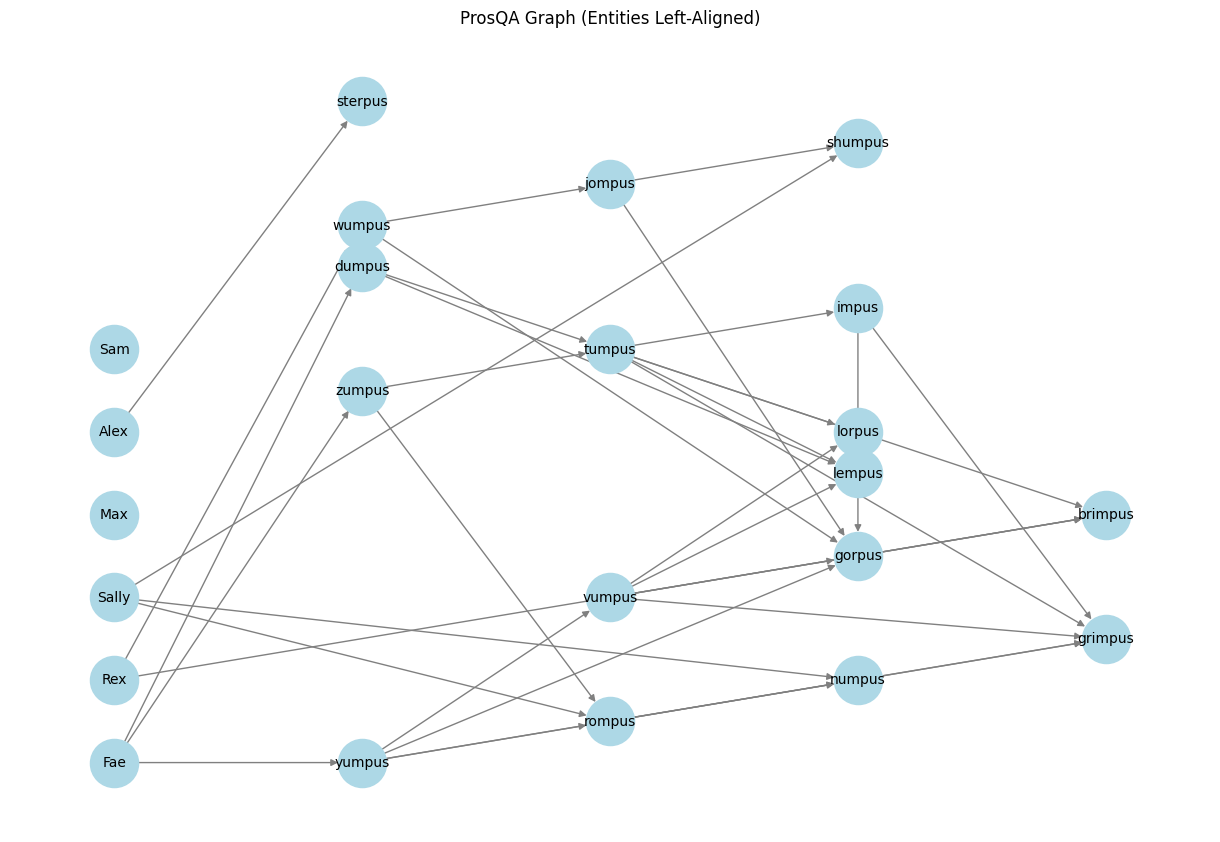

In [21]:
plt.figure(figsize=(12, 8))
pos = compute_custom_layout(G, labels)
nx.draw(G, pos, with_labels=False, arrows=True, node_size=1200, node_color='lightblue', edge_color='gray')
nx.draw_networkx_labels(G, pos, labels=node_names, font_size=10)
plt.title('ProsQA Graph (Entities Left-Aligned)')
plt.axis('off')
plt.show()


In [22]:
def is_reachable(G, src, tgt):
    return nx.has_path(G, src, tgt)

def generate_prosqa_question(G, labels, node_names):
    entity_node = 0
    concept_a_candidates = [n for n in G.nodes if labels[n] == 1 and G.out_degree(n) == 0 and is_reachable(G, entity_node, n)]
    concept_b_candidates = [n for n in G.nodes if labels[n] == 2 and G.out_degree(n) == 0 and not is_reachable(G, entity_node, n)]

    if not concept_a_candidates or not concept_b_candidates:
        return None  # can't generate a valid question

    concept_a = random.choice(concept_a_candidates)
    concept_b = random.choice(concept_b_candidates)

    # Randomly permute choices to avoid position bias
    if random.random() < 0.5:
        correct = node_names[concept_a]
        choices = (node_names[concept_a], node_names[concept_b])
    else:
        correct = node_names[concept_a]
        choices = (node_names[concept_b], node_names[concept_a])

    question = f"Is {node_names[entity_node]} a {choices[0]} or {choices[1]}?"
    answer = correct
    return question, answer


In [23]:
question_answer = generate_prosqa_question(G, labels, node_names)
if question_answer:
    question, answer = question_answer
    print("Q:", question)
    print("A:", answer)
else:
    print("Could not generate a valid question.")


Q: Is Fae a shumpus or grimpus?
A: grimpus
